# Import the library needed


In [1]:
# the xgboost library is install externally in anaconda-navigator
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.feature_selection import f_regression
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


# Load the dataset

In [2]:
# The ID column is stored externally for later purpose
# Then, the ID and pCR (outcome) columns are dropped as these two column will not be used in regression prediction

all_df=pd.read_excel("trainDataset.xls",index_col=False)
all_df = all_df.drop(['pCR (outcome)'],axis=1)
# all_df = all_df.drop(['ID','pCR (outcome)'],axis=1)

# Data Cleaning and Pre-processing

In [3]:
# Determine the missing value (999) in the datasets

all_df[all_df.eq(999).any(axis=1)]

,ID,RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
218,TRG002681,50.000000,47.255305,1,1,0,0,999,999,999,...,0.555687,0.555687,2.209691,0.000821,2.507519e+07,8.909011,0.028160,0.003241,0.000008,0.025185
253,TRG002733,45.000000,46.639288,1,1,0,0,999,999,999,...,0.318539,0.318539,3.027169,0.004115,5.418705e+05,14.395120,0.018432,0.040593,0.001791,0.015474
258,TRG002742,42.000000,56.919918,0,0,0,1,999,3,999,...,0.346553,0.346553,3.698274,0.004569,4.016071e+06,168.506539,0.001617,0.059487,0.003546,0.001411
285,TRG002782,38.000000,66.800000,1,999,999,999,3,3,1,...,0.627560,0.627560,1.994841,0.001028,1.434113e+07,150.821958,0.001886,0.057344,0.004716,0.001705
387,TRG002944,55.083333,28.300000,0,0,0,1,3,1,1,...,0.300230,0.300229,2.750000,0.003303,5.709332e+05,13.723543,0.019693,0.041933,0.002050,0.019120


In [4]:
# Drop the row that contain missing value (999)
# Separate the datasets into X (input) and output (Y)

cleaned_data = all_df[~all_df.eq(999).any(axis=1)]
X = cleaned_data.drop(['ID','RelapseFreeSurvival (outcome)'],axis=1)
y = cleaned_data['RelapseFreeSurvival (outcome)']
ID = cleaned_data['ID']
print(X.shape)
print(y.shape)


(395, 117)
(395,)


# Normalize data before feature selection and model training

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()
# scaler = MinMaxScaler()
Xs = scaler.fit_transform(X)
Xs

array([[-1.00599777, -1.08181776, -0.82080985, ...,  2.64536293,
         2.90207816, -0.24760797],
       [-1.1908398 ,  0.92437011,  1.21830896, ..., -0.52436545,
        -0.59031918, -0.22247632],
       [-1.93020791, -1.08181776, -0.82080985, ..., -0.69170221,
        -0.64669977, -0.19876117],
       ...,
       [ 1.56330644,  0.92437011, -0.82080985, ..., -0.06027399,
        -0.27176946, -0.24236922],
       [-0.54389269,  0.92437011, -0.82080985, ..., -0.80493971,
        -0.67255268, -0.05942538],
       [ 0.31562274, -1.08181776, -0.82080985, ..., -0.03737233,
        -0.3478796 , -0.22471255]])

# Feature Selection

In [6]:
# The SelectKBest is used with Gridsearchcv and XGBRegressor to perform feature selection before training the model
# The best features amount will be shown after the grid search

cv = KFold(n_splits=5, random_state=1, shuffle=True)

model = XGBRegressor()
# cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
fs = SelectKBest(score_func=f_regression)
pipeline = Pipeline(steps=[('sel',fs), ('rgs', model)])
params = [{'sel__k':[i for i in range(1, X.shape[1]+1)]}]

# define the grid search to find the best feature
search = GridSearchCV(pipeline, params, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv)
results = search.fit(Xs, y)

# Show the best score and parameter obtained after grid search
print('Best MAE: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)

means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(">%.3f with: %r" % (mean, param))

Best MAE: -20.490
Best Config: {'sel__k': 24}
>-25.634 with: {'sel__k': 1}
>-25.276 with: {'sel__k': 2}
>-25.233 with: {'sel__k': 3}
>-23.655 with: {'sel__k': 4}
>-23.517 with: {'sel__k': 5}
>-23.714 with: {'sel__k': 6}
>-23.254 with: {'sel__k': 7}
>-23.008 with: {'sel__k': 8}
>-22.085 with: {'sel__k': 9}
>-21.947 with: {'sel__k': 10}
>-21.150 with: {'sel__k': 11}
>-21.443 with: {'sel__k': 12}
>-22.227 with: {'sel__k': 13}
>-22.108 with: {'sel__k': 14}
>-22.176 with: {'sel__k': 15}
>-21.766 with: {'sel__k': 16}
>-21.631 with: {'sel__k': 17}
>-21.781 with: {'sel__k': 18}
>-21.763 with: {'sel__k': 19}
>-21.736 with: {'sel__k': 20}
>-22.340 with: {'sel__k': 21}
>-22.059 with: {'sel__k': 22}
>-21.540 with: {'sel__k': 23}
>-20.490 with: {'sel__k': 24}
>-21.215 with: {'sel__k': 25}
>-21.188 with: {'sel__k': 26}
>-20.827 with: {'sel__k': 27}
>-21.524 with: {'sel__k': 28}
>-21.554 with: {'sel__k': 29}
>-21.439 with: {'sel__k': 30}
>-21.755 with: {'sel__k': 31}
>-21.722 with: {'sel__k': 32}
>-2

In [7]:
# Obtain the number of best feature that will be chosen
import re
num_col = int(re.search(r'\d+', str(results.best_params_)).group())
num_col

24

# Select the best features obtain from the result above and extract from the input datasets (X) 

In [8]:
selector = SelectKBest(score_func=f_regression, k=num_col)
new_x = selector.fit_transform(Xs, y)

In [9]:
# Show the features selected after feature selection

cols = selector.get_support(indices=True)
new_all_df = X.iloc[:,cols]
print(new_all_df.shape)
new_all_df.describe()

(395, 24)


,ChemoGrade,TumourStage,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Variance,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_ZonePercentage
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,...,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,3.950000e+02,395.000000
mean,2.402532,2.584810,23.098152,46.974072,47.700576,44.740659,47.463166,55.758998,20140.356540,31.321857,...,2.806193,3.982808,0.690337,5.029484,0.505769,1.732676,0.769428,0.003992,5.543508e+07,0.003321
std,0.501261,0.889745,9.942466,29.815861,23.879496,25.860421,27.302820,31.164537,34147.704003,14.948567,...,0.790059,1.377606,0.212727,1.440978,0.170694,0.480601,0.494837,0.002107,7.398741e+08,0.002420
min,1.000000,1.000000,5.488466,12.466885,12.165525,13.038405,12.369317,15.524175,522.541667,9.197979,...,1.703169,1.789861,0.278008,2.609159,0.174026,0.450734,0.137128,0.000496,1.446278e+04,0.000008
25%,2.000000,2.000000,16.527720,28.190264,31.144823,28.965312,30.083218,34.633780,5632.979166,20.954383,...,2.327211,3.067744,0.534178,4.010377,0.379549,1.412838,0.442676,0.002392,3.685894e+05,0.001345
50%,2.000000,2.000000,21.554273,38.984484,40.607881,38.327536,39.446166,46.882833,11919.875000,27.583651,...,2.644304,3.711769,0.666808,4.723785,0.489413,1.636014,0.658301,0.003983,9.885922e+05,0.002885
75%,3.000000,3.000000,27.744913,58.169823,59.117826,54.447206,57.831476,68.562443,23353.979165,37.904821,...,3.029886,4.485584,0.819864,5.534179,0.616396,1.966638,0.983977,0.005243,2.702783e+06,0.004766
max,3.000000,4.000000,92.516207,326.866827,155.756220,241.530536,237.033753,242.614921,528765.458300,126.141700,...,9.176538,11.180875,1.664640,12.240681,1.253614,3.786760,3.959871,0.014780,1.419410e+10,0.011301


# Normalize the new input(X) after feature selection before model training

In [10]:
new_Xs = scaler.fit_transform(new_all_df)
new_Xs

array([[ 1.19344226, -0.65811165,  0.06886136, ...,  0.0197483 ,
        -0.07343578, -0.41659739],
       [ 1.19344226, -0.65811165, -0.23995184, ...,  0.50949351,
        -0.07420671,  0.9480735 ],
       [-0.80405644, -0.65811165, -0.14484878, ...,  0.798531  ,
        -0.07449158,  1.41941677],
       ...,
       [ 1.19344226,  0.46723078,  0.84628224, ..., -1.2532167 ,
        -0.06786834, -0.91354143],
       [-0.80405644, -0.65811165, -0.85373197, ...,  0.94846812,
        -0.07482274,  1.40062824],
       [-0.80405644, -0.65811165, -0.42538421, ...,  0.76034301,
        -0.07447616,  0.85615873]])

# Hyperparameter Tuning with GridSearchCV for XGBRegressor

In [11]:
model = XGBRegressor()
cv = KFold(n_splits=5, random_state=1, shuffle=True)

# Parameter settings for XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.01, 0.05, .1], #so called `eta` value
              'max_depth': [1, 5, 6, 7],
              'min_child_weight': [4],
              'subsample': [0.7],
              'colsample_bytree': [0.3, 0.5, 0.8],
              'gamma':[0,1,5],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(model,
                        parameters,
                        cv = cv,
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(new_Xs, y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[15:04:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=...
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.5, 0.8],
                  

In [12]:
# Show the best parameter determine 

print('Best parameters found:\n', xgb_grid.best_params_)

Best parameters found:
 {'colsample_bytree': 0.8, 'gamma': 5, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'subsample': 0.7}


# Split the data for testing the model with hyperparameter optimization

In [13]:
from sklearn.model_selection import train_test_split
Xs_train, Xs_test, y_train, y_test = train_test_split(new_Xs, y, test_size=0.2, random_state=1)

# Fit the best parameter settings into the model and train to predict the test data

In [14]:
model =  XGBRegressor().set_params(**xgb_grid.best_params_)
rgs = model.fit(Xs_train, y_train)
y_pred = rgs.predict(Xs_test)

[15:04:58] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


# Evaluate the result

In [15]:
# Compare the difference between the predicted value and actual value
pred_data = pd.DataFrame({'Actual':y_test,'Predicted':y_pred,'Difference':y_test-y_pred})

print(pred_data)

        Actual  Predicted  Difference
146  67.000000  44.008324   22.991676
383  56.083333  71.270027  -15.186694
248  43.000000  61.797066  -18.797066
197  57.000000  64.069435   -7.069435
372  58.416667  51.327560    7.089106
..         ...        ...         ...
41   98.000000  59.695148   38.304852
204  55.000000  56.398090   -1.398090
366  62.083333  63.668350   -1.585017
234  47.000000  20.579168   26.420832
278  39.000000  57.536633  -18.536633

[79 rows x 3 columns]


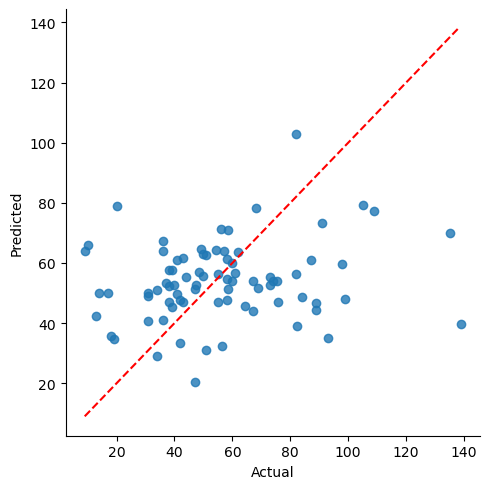

In [16]:
# Plot the graph of actual and predicted diagram to visualize

data_results = pd.DataFrame({'Actual':y_test,'Predicted':y_pred})
sns.lmplot(x='Actual',y='Predicted',data=data_results,fit_reg=False)
d_line= np.arange(data_results.min().min(), data_results.max().max())
plt.plot(d_line, d_line, color='red', linestyle='--')
plt.show()

# Determine the accuracy by mean absolute error, mean squared error, root mean squared error and r2 score 

In [31]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


cv = KFold(n_splits=5, random_state=1, shuffle=True)
model =  XGBRegressor().set_params(**xgb_grid.best_params_)

# Determine on feature selected input variable

r2_scores = cross_val_score(model, new_Xs, y, scoring='r2', cv=cv, n_jobs=-1)
print("K-Fold R2 score =", round(np.mean(r2_scores),2))

mae = cross_val_score(model, new_Xs, y, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)
print("K-Fold mean absolute error score =", round(np.mean(np.absolute(mae)),2))

#K-Fold Mean Squared Error
MSE = cross_val_score(model, new_Xs, y, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)
print("K-Fold Mean Squared Error =", round(np.mean(np.absolute(MSE)),2))

#K-Fold Root Mean Squared Error
RMSE = cross_val_score(model, new_Xs, y, scoring='neg_root_mean_squared_error',
                         cv=cv, n_jobs=-1)
print("K-Fold Root Mean Squared error =", round(np.mean(np.absolute(RMSE)),2))

K-Fold R2 score = 0.1
K-Fold mean absolute error score = 20.22
K-Fold Mean Squared Error = 643.32
K-Fold Root Mean Squared error = 25.31


# Xs-train & y-train

In [32]:
r2_scores = cross_val_score(model, Xs_train, y_train, scoring='r2', cv=cv, n_jobs=-1)
print("K-Fold R2 score =", round(np.mean(r2_scores),2))

mae = cross_val_score(model, Xs_train, y_train, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)
print("K-Fold mean absolute error score =", round(np.mean(np.absolute(mae)),2))

#K-Fold Mean Squared Error
MSE = cross_val_score(model, Xs_train, y_train, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)
print("K-Fold Mean Squared Error =", round(np.mean(np.absolute(MSE)),2))

#K-Fold Root Mean Squared Error
RMSE = cross_val_score(model, Xs_train, y_train, scoring='neg_root_mean_squared_error',
                         cv=cv, n_jobs=-1)
print("K-Fold Root Mean Squared error =", round(np.mean(np.absolute(RMSE)),2))

K-Fold R2 score = 0.08
K-Fold mean absolute error score = 20.73
K-Fold Mean Squared Error = 659.94
K-Fold Root Mean Squared error = 25.66


# Xs-test & y-test

In [33]:
r2_scores = cross_val_score(model, Xs_test, y_test, scoring='r2', cv=cv, n_jobs=-1)
print("K-Fold R2 score =", round(np.mean(r2_scores),2))

mae = cross_val_score(model, Xs_test, y_test, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)
print("K-Fold mean absolute error score =", round(np.mean(np.absolute(mae)),2))

#K-Fold Mean Squared Error
MSE = cross_val_score(model, Xs_test, y_test, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)
print("K-Fold Mean Squared Error =", round(np.mean(np.absolute(MSE)),2))

#K-Fold Root Mean Squared Error
RMSE = cross_val_score(model, Xs_test, y_test, scoring='neg_root_mean_squared_error',
                         cv=cv, n_jobs=-1)
print("K-Fold Root Mean Squared error =", round(np.mean(np.absolute(RMSE)),2))

K-Fold R2 score = -0.56
K-Fold mean absolute error score = 23.7
K-Fold Mean Squared Error = 957.14
K-Fold Root Mean Squared error = 30.43
